# Project
## Mengxiang Jiang

The majority of the code and images here comes from the [Companion Jupyter notebooks for the book "Deep Learning with Python"](https://github.com/fchollet/deep-learning-with-python-notebooks) by François Chollet, specifically chapter 12.
If the code comes from somewhere else it will have a source linked to the original.\
[Short Video Link](https://youtu.be/-LP7932s29M)\
[Long Video Link](https://youtu.be/M4aIFlE_EaA)

### Implementing a VAE with Keras
**VAE encoder network**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

encoder.summary()

2023-05-02 22:15:22.962199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 22:15:23.033768: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 16)   2320        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 32)   4640        ['conv2d_1[0][0]']         

2023-05-02 22:15:23.916586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 22:15:23.919891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 22:15:23.919978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 22:15:23.920239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

**Latent-space-sampling layer**

In [2]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**VAE decoder network, mapping latent space points to images**

In [3]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 32))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 reshape (Reshape)           (None, 4, 4, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         18496     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       9248

**VAE model with custom `train_step()`**

In [4]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Processing Cats and Dogs Audio Files
Using code examples from Audio Data Processing in Python by Rob Mulla [source](https://youtu.be/ZqpSb5p1xQo)

**imports for audio**

In [5]:
import os
import numpy as np
import librosa
import IPython.display as ipd

**Playing Audio Example**

In [6]:
example = 'cats_dogs/cat_55.wav'

ipd.Audio(example)

**Read Audio Example**

In [7]:
y, sr = librosa.load(example)
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-4.7695365e-13 -2.7231846e-13  6.0946902e-13 -1.0876644e-12
  1.0821471e-13 -7.5358697e-13  1.1852891e-12 -3.9097398e-13
  5.9609826e-13  7.5963156e-13]
shape y: (20360,)
sr: 22050


**Plot of Audio File**

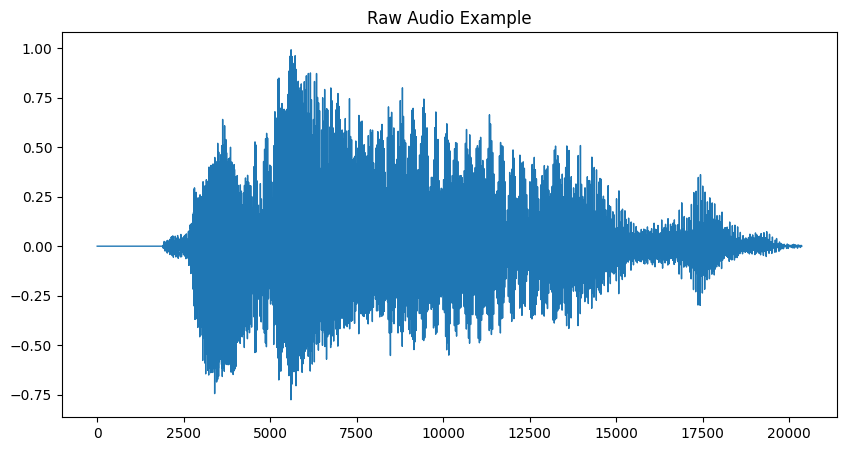

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                  color=color_pal[0])
plt.show()

**Plot of Trimmed Audio File**

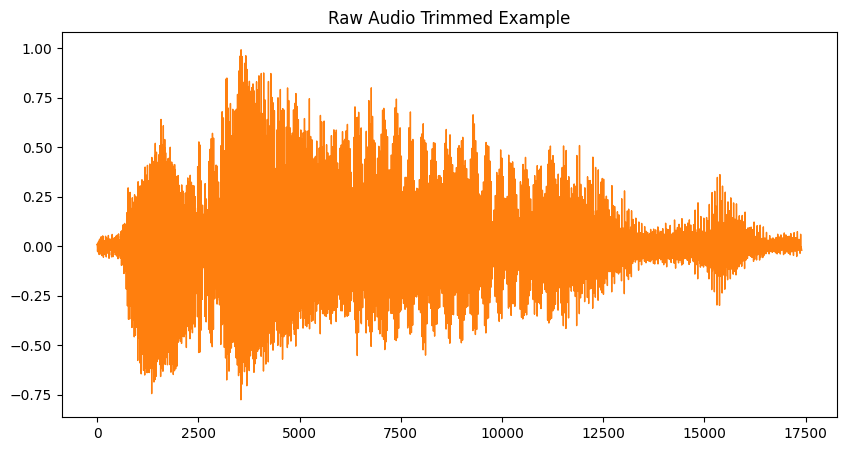

In [9]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                  color=color_pal[1])
plt.show()

In [10]:
y_truncated = y_trimmed[:8157]
D = librosa.stft(y_truncated, n_fft=256)[:128]
print(D)

[[-1.5450765e-01+0.0000000e+00j -1.2125368e-01+0.0000000e+00j
  -2.5592126e-02+0.0000000e+00j ... -5.5398576e-02+0.0000000e+00j
  -9.5129628e-03+0.0000000e+00j  5.5073276e-02+0.0000000e+00j]
 [ 1.5119709e-01-3.3558540e-02j  3.9501935e-02+6.8126164e-02j
   1.9317612e-02+2.7503161e-02j ...  6.7590117e-02-1.1957300e-02j
  -8.6155636e-03+5.3830512e-02j -3.7132040e-02+7.5932462e-03j]
 [-1.3415165e-01+5.3168114e-02j  9.2390053e-02-8.1454897e-03j
  -1.0553519e-02-3.6753919e-02j ... -7.6347515e-02+9.1338065e-03j
   2.5777645e-02-2.9614935e-02j -7.7043902e-03-3.3790688e-03j]
 ...
 [-3.3752809e-03+4.7797483e-05j -2.2966644e-05-1.6797942e-03j
   4.4584763e-07-1.0675447e-07j ... -1.2628220e-06+9.7183272e-07j
   2.7232640e-03+1.6214006e-03j -8.0602774e-03+1.3595354e-02j]
 [ 3.3769177e-03-3.2050473e-05j -1.6809161e-03+1.5288759e-05j
   4.2058605e-07-8.4614648e-08j ... -1.5176213e-06+1.3024639e-06j
   5.1871908e-04+3.1291379e-03j -2.6195773e-03-1.5580659e-02j]
 [-3.3784988e-03+1.6054504e-05j  7.39804

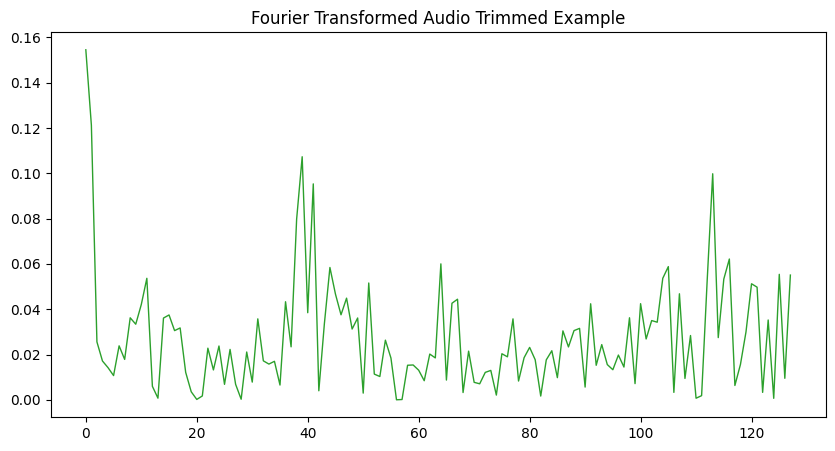

In [11]:
pd.Series(np.abs(D)[0]).plot(figsize=(10, 5),
                  lw=1,
                  title='Fourier Transformed Audio Trimmed Example',
                  color=color_pal[2])
plt.show()

In [27]:
y_hat = librosa.istft(np.abs(D))
print(y_hat.shape)
ipd.Audio(y_hat, rate=sr)

(8001,)


In [12]:
y_hat = librosa.griffinlim(np.abs(D))
print(y_hat.shape)
ipd.Audio(y_hat, rate=sr)

(8001,)


**create STFT data**

In [13]:
SOUND_FILES = 'cats_dogs/'
stft_data = []
for sound in os.listdir(SOUND_FILES):
    x, sr = librosa.load(SOUND_FILES + sound)
    x_trimmed, _ = librosa.effects.trim(x, top_db=20)
    # truncate to only 0.37 seconds (8157 samples)
    x_trimmed_truncated1 = x_trimmed[:8157]
    #x_trimmed_truncated2 = x_trimmed[-8157:]
    X1 = librosa.stft(x_trimmed_truncated1, n_fft=256)[:128]
    #X2 = librosa.stft(x_trimmed_truncated2, n_fft=256)[:128]
    stft_data.append(np.abs(X1))
    #stft_data.append(np.abs(X2))



In [14]:
stft_data = np.array(stft_data)
print(stft_data.shape)
stft_min = np.min(stft_data)
stft_max = np.max(stft_data)
print(stft_max)
stft_data = np.expand_dims(stft_data, -1).astype("float32")
stft_data = (stft_data-stft_min)/(stft_max-stft_min)
print(stft_data.shape)
np.random.shuffle(stft_data)


(277, 128, 128)
113.416275
(277, 128, 128, 1)


**Training the VAE**

In [15]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(stft_data, epochs=1000)

Epoch 1/1000


2023-05-02 22:15:28.692620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-02 22:15:29.647904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-02 22:15:29.823601: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1baf45f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-02 22:15:29.823619: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-05-02 22:15:29.826453: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-02 22:15:29.888685: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the 

9/9 [==============================] - 4s 23ms/step - total_loss: 11244.0967 - reconstruction_loss: 11244.0967 - kl_loss: 7.4574e-05
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 10786.3701 - reconstruction_loss: 10786.3623 - kl_loss: 0.0069
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 8142.2051 - reconstruction_loss: 8141.2065 - kl_loss: 0.8607
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 1743.7896 - reconstruction_loss: 1465.0336 - kl_loss: 289.1030
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 682.2356 - reconstruction_loss: 676.8148 - kl_loss: 5.5353
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 598.6609 - reconstruction_loss: 596.9069 - kl_loss: 1.7699
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - total_loss: 542.2032 - reconstruction_loss: 541.1569 - kl_loss: 1.0550
Epoch 8/1000
9/9 [=================

9/9 [==============================] - 0s 6ms/step - total_loss: 321.9099 - reconstruction_loss: 319.7169 - kl_loss: 2.1985
Epoch 61/1000
9/9 [==============================] - 0s 7ms/step - total_loss: 320.7005 - reconstruction_loss: 318.4969 - kl_loss: 2.2016
Epoch 62/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 321.9310 - reconstruction_loss: 319.7290 - kl_loss: 2.2023
Epoch 63/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 320.6253 - reconstruction_loss: 318.4708 - kl_loss: 2.1573
Epoch 64/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 321.4499 - reconstruction_loss: 319.2877 - kl_loss: 2.1675
Epoch 65/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 320.9410 - reconstruction_loss: 318.7687 - kl_loss: 2.1665
Epoch 66/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 320.5876 - reconstruction_loss: 318.4026 - kl_loss: 2.1845
Epoch 67/1000
9/9 [=============================

9/9 [==============================] - 0s 6ms/step - total_loss: 311.7421 - reconstruction_loss: 309.4574 - kl_loss: 2.2841
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 314.5522 - reconstruction_loss: 312.2463 - kl_loss: 2.3095
Epoch 121/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 313.4991 - reconstruction_loss: 311.1781 - kl_loss: 2.3210
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 311.1984 - reconstruction_loss: 308.9240 - kl_loss: 2.2760
Epoch 123/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 314.3304 - reconstruction_loss: 312.0100 - kl_loss: 2.3204
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 312.5431 - reconstruction_loss: 310.2453 - kl_loss: 2.2987
Epoch 125/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 313.1627 - reconstruction_loss: 310.8906 - kl_loss: 2.2653
Epoch 126/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 312.7917 - reconstruction_loss: 310.3575 - kl_loss: 2.4385
Epoch 179/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 310.8497 - reconstruction_loss: 308.5114 - kl_loss: 2.3314
Epoch 180/1000
9/9 [==============================] - 0s 5ms/step - total_loss: 310.2127 - reconstruction_loss: 307.7937 - kl_loss: 2.4165
Epoch 181/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 308.4267 - reconstruction_loss: 306.1026 - kl_loss: 2.3294
Epoch 182/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 306.5040 - reconstruction_loss: 304.1802 - kl_loss: 2.3290
Epoch 183/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 312.2169 - reconstruction_loss: 309.8321 - kl_loss: 2.3802
Epoch 184/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 311.0242 - reconstruction_loss: 308.7068 - kl_loss: 2.3192
Epoch 185/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 305.8006 - reconstruction_loss: 303.4249 - kl_loss: 2.3783
Epoch 238/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 308.6996 - reconstruction_loss: 306.3029 - kl_loss: 2.3940
Epoch 239/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 307.3514 - reconstruction_loss: 304.9247 - kl_loss: 2.4309
Epoch 240/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 305.3247 - reconstruction_loss: 302.9640 - kl_loss: 2.3582
Epoch 241/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 305.1526 - reconstruction_loss: 302.8300 - kl_loss: 2.3269
Epoch 242/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 304.9448 - reconstruction_loss: 302.5906 - kl_loss: 2.3628
Epoch 243/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 307.2743 - reconstruction_loss: 304.8715 - kl_loss: 2.4034
Epoch 244/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 306.3212 - reconstruction_loss: 303.9830 - kl_loss: 2.3416
Epoch 297/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 307.6425 - reconstruction_loss: 305.2276 - kl_loss: 2.4150
Epoch 298/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 306.3309 - reconstruction_loss: 303.9403 - kl_loss: 2.3838
Epoch 299/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 304.0049 - reconstruction_loss: 301.6107 - kl_loss: 2.3900
Epoch 300/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 309.0138 - reconstruction_loss: 306.6871 - kl_loss: 2.3248
Epoch 301/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 305.7231 - reconstruction_loss: 303.2794 - kl_loss: 2.4422
Epoch 302/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 305.7833 - reconstruction_loss: 303.4749 - kl_loss: 2.3099
Epoch 303/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 303.7997 - reconstruction_loss: 301.3534 - kl_loss: 2.4498
Epoch 356/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 306.9504 - reconstruction_loss: 304.5907 - kl_loss: 2.3585
Epoch 357/1000
9/9 [==============================] - 0s 7ms/step - total_loss: 304.2571 - reconstruction_loss: 301.8118 - kl_loss: 2.4543
Epoch 358/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 305.9315 - reconstruction_loss: 303.5304 - kl_loss: 2.4040
Epoch 359/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 305.2461 - reconstruction_loss: 302.7812 - kl_loss: 2.4675
Epoch 360/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 306.3610 - reconstruction_loss: 303.9557 - kl_loss: 2.4065
Epoch 361/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 309.1614 - reconstruction_loss: 306.8024 - kl_loss: 2.3590
Epoch 362/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 304.0283 - reconstruction_loss: 301.5745 - kl_loss: 2.4561
Epoch 415/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 305.4266 - reconstruction_loss: 302.9929 - kl_loss: 2.4341
Epoch 416/1000
9/9 [==============================] - 0s 5ms/step - total_loss: 300.6147 - reconstruction_loss: 298.1057 - kl_loss: 2.5099
Epoch 417/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 302.7428 - reconstruction_loss: 300.2381 - kl_loss: 2.5035
Epoch 418/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 305.2350 - reconstruction_loss: 302.7502 - kl_loss: 2.4783
Epoch 419/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 307.4186 - reconstruction_loss: 304.8993 - kl_loss: 2.5149
Epoch 420/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 305.1975 - reconstruction_loss: 302.7418 - kl_loss: 2.4505
Epoch 421/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 302.2650 - reconstruction_loss: 299.7441 - kl_loss: 2.5203
Epoch 474/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 302.8513 - reconstruction_loss: 300.3598 - kl_loss: 2.4903
Epoch 475/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 301.4977 - reconstruction_loss: 298.9965 - kl_loss: 2.5037
Epoch 476/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 303.2023 - reconstruction_loss: 300.7212 - kl_loss: 2.4853
Epoch 477/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.9829 - reconstruction_loss: 297.4505 - kl_loss: 2.5285
Epoch 478/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 304.2367 - reconstruction_loss: 301.7419 - kl_loss: 2.4961
Epoch 479/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 303.9314 - reconstruction_loss: 301.3917 - kl_loss: 2.5391
Epoch 480/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 304.0818 - reconstruction_loss: 301.5906 - kl_loss: 2.4916
Epoch 533/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 303.4290 - reconstruction_loss: 300.8218 - kl_loss: 2.6012
Epoch 534/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 301.7143 - reconstruction_loss: 299.1637 - kl_loss: 2.5544
Epoch 535/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 300.3129 - reconstruction_loss: 297.8229 - kl_loss: 2.4944
Epoch 536/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 301.5990 - reconstruction_loss: 299.0724 - kl_loss: 2.5232
Epoch 537/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 302.7442 - reconstruction_loss: 300.2270 - kl_loss: 2.5199
Epoch 538/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.3737 - reconstruction_loss: 296.8243 - kl_loss: 2.5569
Epoch 539/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 300.5637 - reconstruction_loss: 298.0224 - kl_loss: 2.5423
Epoch 592/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.9904 - reconstruction_loss: 297.3371 - kl_loss: 2.6572
Epoch 593/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 300.5556 - reconstruction_loss: 297.9523 - kl_loss: 2.5996
Epoch 594/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 300.9620 - reconstruction_loss: 298.3320 - kl_loss: 2.6394
Epoch 595/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 301.7776 - reconstruction_loss: 299.2018 - kl_loss: 2.5681
Epoch 596/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 300.5394 - reconstruction_loss: 297.8504 - kl_loss: 2.6940
Epoch 597/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 303.9834 - reconstruction_loss: 301.3064 - kl_loss: 2.6748
Epoch 598/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 302.5190 - reconstruction_loss: 299.9034 - kl_loss: 2.6108
Epoch 651/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.6240 - reconstruction_loss: 296.9822 - kl_loss: 2.6403
Epoch 652/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 300.0796 - reconstruction_loss: 297.4314 - kl_loss: 2.6426
Epoch 653/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 302.0794 - reconstruction_loss: 299.4827 - kl_loss: 2.5935
Epoch 654/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 301.4103 - reconstruction_loss: 298.7312 - kl_loss: 2.6754
Epoch 655/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 300.4209 - reconstruction_loss: 297.7294 - kl_loss: 2.6946
Epoch 656/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 297.3975 - reconstruction_loss: 294.8085 - kl_loss: 2.5982
Epoch 657/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 298.4133 - reconstruction_loss: 295.7094 - kl_loss: 2.7071
Epoch 710/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.4046 - reconstruction_loss: 296.7806 - kl_loss: 2.6202
Epoch 711/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.7062 - reconstruction_loss: 297.1232 - kl_loss: 2.5820
Epoch 712/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 301.7836 - reconstruction_loss: 299.0526 - kl_loss: 2.7301
Epoch 713/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 298.9056 - reconstruction_loss: 296.2005 - kl_loss: 2.7028
Epoch 714/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.3459 - reconstruction_loss: 296.6180 - kl_loss: 2.7210
Epoch 715/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 298.3243 - reconstruction_loss: 295.5723 - kl_loss: 2.7527
Epoch 716/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 299.2688 - reconstruction_loss: 296.4982 - kl_loss: 2.7649
Epoch 769/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.2540 - reconstruction_loss: 296.4792 - kl_loss: 2.7742
Epoch 770/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.7936 - reconstruction_loss: 297.0483 - kl_loss: 2.7472
Epoch 771/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 297.7836 - reconstruction_loss: 295.0419 - kl_loss: 2.7489
Epoch 772/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.5207 - reconstruction_loss: 296.7769 - kl_loss: 2.7462
Epoch 773/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 298.5929 - reconstruction_loss: 295.8687 - kl_loss: 2.7206
Epoch 774/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 300.4621 - reconstruction_loss: 297.7791 - kl_loss: 2.6700
Epoch 775/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 298.7585 - reconstruction_loss: 295.8812 - kl_loss: 2.8829
Epoch 828/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 297.6945 - reconstruction_loss: 294.9172 - kl_loss: 2.7826
Epoch 829/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 298.0197 - reconstruction_loss: 295.2553 - kl_loss: 2.7713
Epoch 830/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 296.9399 - reconstruction_loss: 294.1360 - kl_loss: 2.8027
Epoch 831/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.0706 - reconstruction_loss: 296.2287 - kl_loss: 2.8331
Epoch 832/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 296.5956 - reconstruction_loss: 293.7503 - kl_loss: 2.8453
Epoch 833/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 297.9528 - reconstruction_loss: 295.2113 - kl_loss: 2.7542
Epoch 834/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 297.3297 - reconstruction_loss: 294.5083 - kl_loss: 2.8246
Epoch 887/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 297.6440 - reconstruction_loss: 294.7528 - kl_loss: 2.8924
Epoch 888/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 296.1391 - reconstruction_loss: 293.2914 - kl_loss: 2.8523
Epoch 889/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.5969 - reconstruction_loss: 296.7316 - kl_loss: 2.8620
Epoch 890/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 297.1029 - reconstruction_loss: 294.2874 - kl_loss: 2.8189
Epoch 891/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.8318 - reconstruction_loss: 297.0178 - kl_loss: 2.8101
Epoch 892/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 298.7056 - reconstruction_loss: 295.8604 - kl_loss: 2.8409
Epoch 893/1000
9/9 [======================

9/9 [==============================] - 0s 6ms/step - total_loss: 299.3248 - reconstruction_loss: 296.3954 - kl_loss: 2.9203
Epoch 946/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 297.3116 - reconstruction_loss: 294.4550 - kl_loss: 2.8518
Epoch 947/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 296.2508 - reconstruction_loss: 293.4436 - kl_loss: 2.7988
Epoch 948/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 297.3460 - reconstruction_loss: 294.4523 - kl_loss: 2.8982
Epoch 949/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 295.6208 - reconstruction_loss: 292.7711 - kl_loss: 2.8592
Epoch 950/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 296.5584 - reconstruction_loss: 293.8012 - kl_loss: 2.7575
Epoch 951/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 299.3183 - reconstruction_loss: 296.5280 - kl_loss: 2.7921
Epoch 952/1000
9/9 [======================

**Sampling a grid of sounds from the 2D latent space**

1/1 [==============================] - 0s 9ms/step


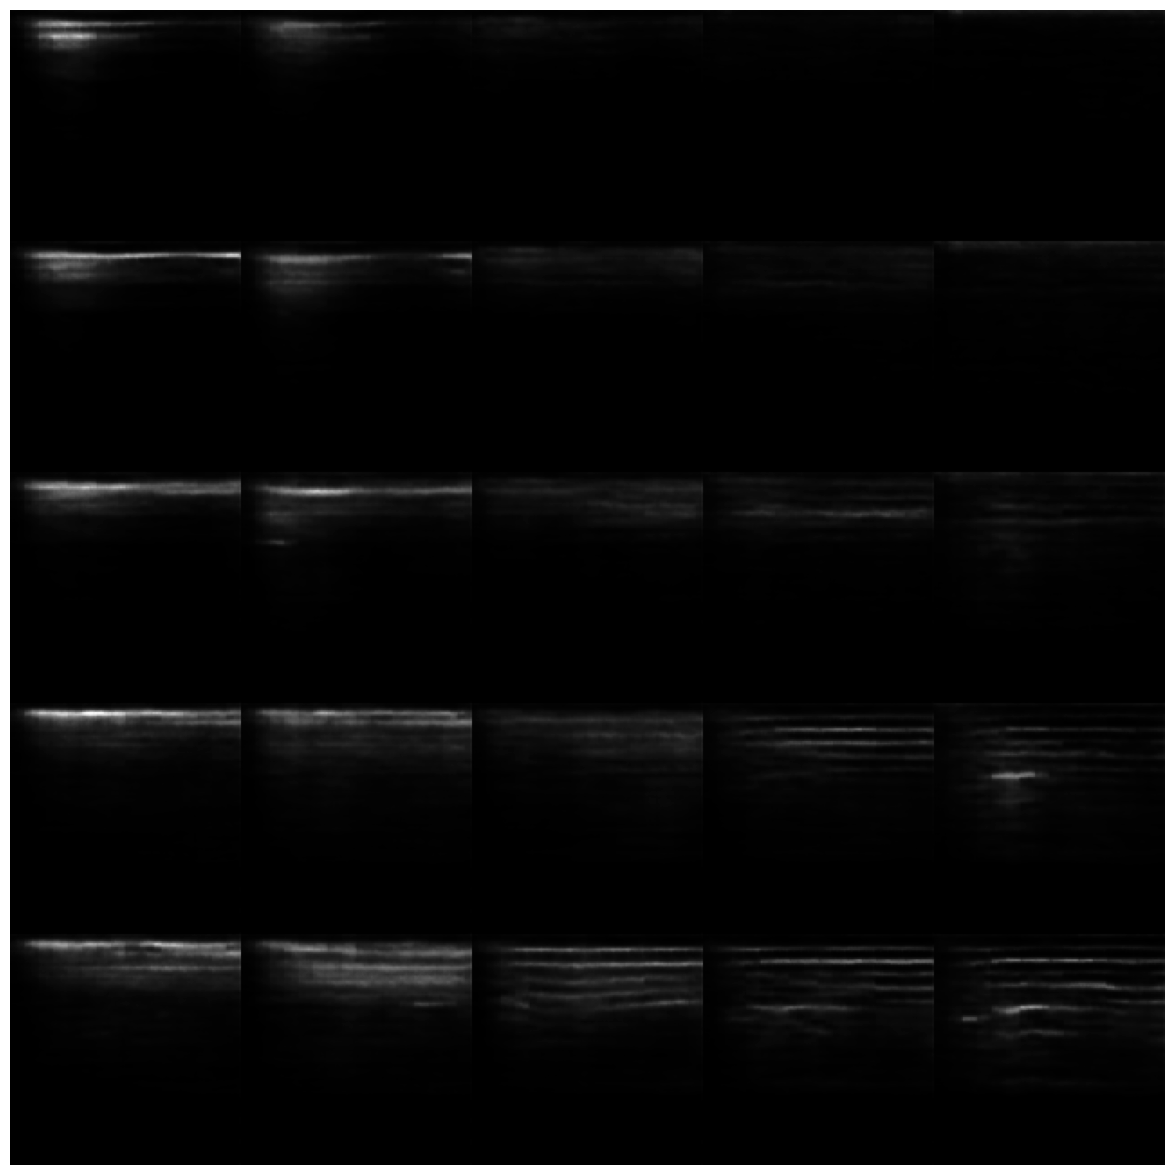

In [16]:
import matplotlib.pyplot as plt

n = 5
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

**Sampling a random sound from the 2D latent space**

In [26]:
import soundfile as sf
import random

z_sample = np.array([[random.uniform(-1, 1), random.uniform(-1, 1)]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 14ms/step


In [18]:
z_sample = np.array([[-1, -1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 59ms/step


In [19]:
z_sample = np.array([[-1, 1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 10ms/step


In [20]:
z_sample = np.array([[1, -1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 10ms/step


In [21]:
z_sample = np.array([[1, 1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 10ms/step
